# Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

## Purpose

An analyst at a big online store together with the marketing department have compiled a list of hypotheses that may help boost revenue.
The goals of this project are:
- to prioritize hypotheses
- launch an A/B test
- analyze the results and decide whether to: 1. Stop the test and consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.



## Data preparation

Let's first upload the datasets and investigate them

In [3]:

hypos = pd.read_csv('/datasets/hypotheses_us.csv', sep=";" )
pd.set_option('max_colwidth', 500)


In [4]:
hypos

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


**Column names are to be converted into lowercase**

In [5]:
hypos.columns = hypos.columns.str.lower()
hypos

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [6]:
orders = pd.read_csv('/datasets/orders_us.csv')

In [7]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


**The date column has a wrong date type and column names are to be converted into lowercase. Let's chage it to datetime**

In [9]:
#Changing columns case to lowercase
orders.columns = orders.columns.str.lower()
display(orders.head(1))

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B


In [10]:
orders['date']=orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [11]:
#Checking if the data type has been changed successfully
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


**Let's check, whether each visitor was assigned to one an only group: either A or B**

In [12]:
#Counting the number of users assigned to more than 1 group
errors = orders.groupby('visitorid').agg({'group':'nunique'}).reset_index().query('group != 1')['visitorid'].count()

print(f'There are: {errors} unique visitors in the orders dataset that are assigned to more than 1 group')

There are: 58 unique visitors in the orders dataset that are assigned to more than 1 group


**Looks like there are mistakes with group assignment in the data. Now, let's establish the scope of the issue.**

In [13]:
#Counting total number of users 
total_visitors = orders.groupby('visitorid').agg({'group':'nunique'}).reset_index()['visitorid'].count()

print(f"There are: {total_visitors} unique visitors in total")

There are: 1031 unique visitors in total


In [14]:
#Erroneous visitor relative to total number

print(f"There are: {errors/total_visitors:.1%} unique visitors in total")


There are: 5.6% unique visitors in total


**The share of erroneous data is not significant. Therefore, it is necessary to drop this data, because it is unclear where the mistakes stem from.**

In [15]:
#Dropping the rows with visitorId, that have been assigned to more than 1 group
errors_to_drop = orders.groupby('visitorid').agg({'group':'nunique'}).reset_index().query('group != 1')['visitorid'].to_list()
orders_filtered = orders[~orders['visitorid'].isin(errors_to_drop)]

print(f"We have filtered {len(orders)-len(orders_filtered)} unique users from the oroginal orders dataset")




We have filtered 181 unique users from the oroginal orders dataset


In [16]:
visits = pd.read_csv('/datasets/visits_us.csv', sep="," )

In [17]:
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [18]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Date column in visits table contains wrong data type, let's fix this.**

In [19]:
visits['date']= visits['date'].astype('datetime64')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


## Prioritizing Hypotheses

The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effortspecified for each.



The task is to:
Apply the ICE framework to prioritize hypotheses. 

Sort them in descending order of priority.


Apply the RICE framework to prioritize hypotheses. 

Sort them in descending order of priority.


Show how the prioritization of hypotheses changes when you use RICE instead of ICE. 

Provide an explanation for the changes.


In [20]:
hypos

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


**Now let's apply the ICE and RICE frameworks to prioritize hypotheses and sort them in descending order of priority.**



In [21]:
# Adding columns for ICE and RICE frameworks 
hypos['ice'] = (hypos['impact']*hypos['confidence'])/hypos['effort'].sort_values(ascending=False)
hypos['rice'] = ((hypos['reach']*hypos['impact']*hypos['confidence'])/hypos['effort']).sort_values(ascending=False)
# Adding rank columns to make for easier comparison between the two frameworks
hypos['ice_rank'] = hypos['ice'].rank(method='min').astype(int)
hypos['rice_rank'] = hypos['rice'].rank(method='min').astype(int)


In [22]:

hypos.sort_values(by=['ice'],ascending=False).round(2)

,hypothesis,reach,impact,confidence,effort,ice,rice,ice_rank,rice_rank
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.2,9,5
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0,8,6
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.0,7,9
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.0,6,6
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0,5,8
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0,4,2
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.0,3,2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0,2,4
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0,1,1


Having ranked both ICE and RICE frameworks, we can conclude, that, overall, the Reach paramater greatly affects the distribution of hypotheses leaders. However, if we were to decide what hypothesis are to be tested last, we could easily come to an agreement, since the bottom half of the table varies eve so slightly.

ICE top hypotheses are: 8,0,7
RICE top hypotheses are: 6,0,7,2
This being said, hypotheses "Add two new channels for attracting traffic. This will bring 30% more users" and "Add a subscription form to all the main pages. This will help you compile a mailing list" can be added to the shortlist for testing, followed by "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size	" (because it would reach a substantial number of users) and "Show banners with current offers and sales on the main page. This will boost conversion" (equally highly ranked on both framework scales).

## A/B Test Analysis

### Graph cumulative revenue by group.

Let's plot two graphs on cumulative revenue by group that differ only in approach: the first graph will be plotted using .cumsum() method and the second uaing lambda function and np.logical_and method along this aggregation.

In [23]:
control = orders_filtered.query('group == "A"').sort_values(by='date')
control['revenue_cum'] = control['revenue'].cumsum()

test = orders_filtered.query('group == "B"').sort_values(by='date')
test['revenue_cum'] = test['revenue'].cumsum()

<Figure size 864x648 with 0 Axes>

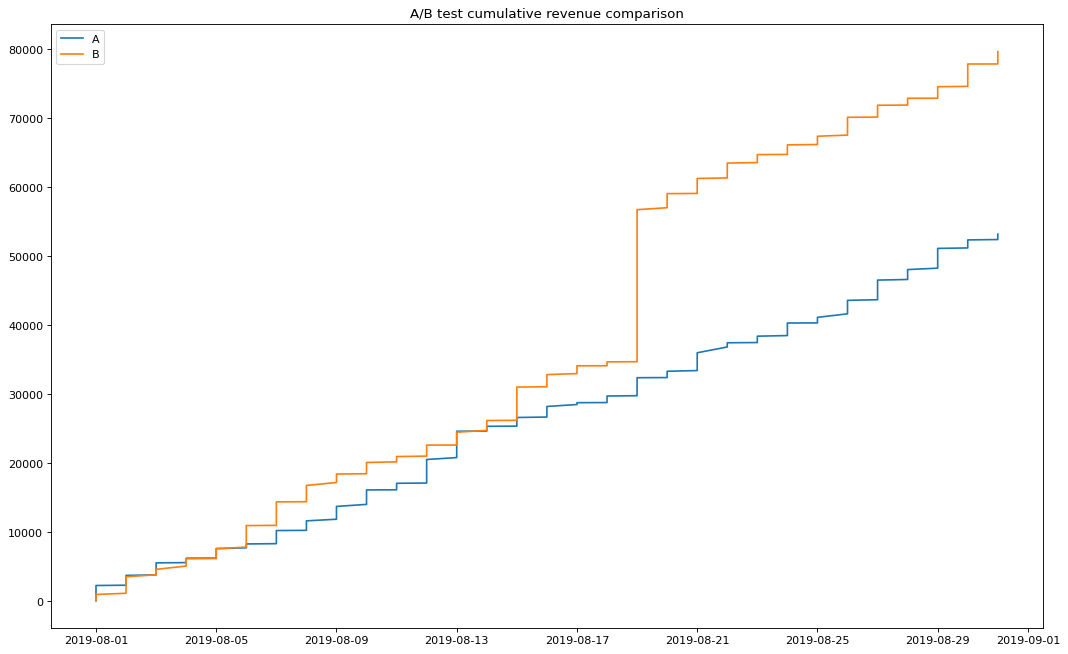

In [24]:
plt.figure(figsize=(12,9))

plt.figure(figsize=(16,10), dpi= 80)
plt.plot(control['date'], control['revenue_cum'], color='tab:blue', label = 'A')
plt.plot(test['date'], test['revenue_cum'], color='tab:orange', label = 'B')
plt.legend()
plt.title("A/B test cumulative revenue comparison")
plt.show()

In [25]:
datesGroups = orders_filtered[['date', 'group']].drop_duplicates()

orders_aggregated = datesGroups.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], orders_filtered['group'] == x['group'])]
                                     .agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

display(orders_aggregated.head())

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


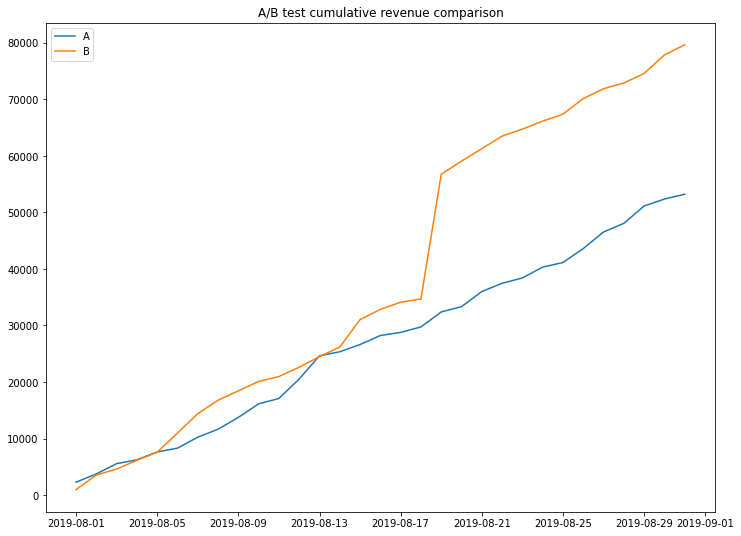

In [26]:
cumulativeRevenueA = orders_aggregated[orders_aggregated['group']=='A'][['date','revenue', 'transactionid']]
cumulativeRevenueB = orders_aggregated[orders_aggregated['group']=='B'][['date','revenue', 'transactionid']]
plt.figure(figsize=(12,9))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label ="A")
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label ="B")
plt.legend()
plt.title("A/B test cumulative revenue comparison")
plt.show()

**Both graphs feature almost identical patterns.
It can be observed, that Group B demonstrates consistently higher revenue across-the-board, with a sudden peak in late August that may be attributed to outliers. This will be investigated later.**

### Graph cumulative average order size by group.


In [27]:
orders_aggregated['avg_check']= orders_aggregated['revenue']/orders_aggregated['transactionid']

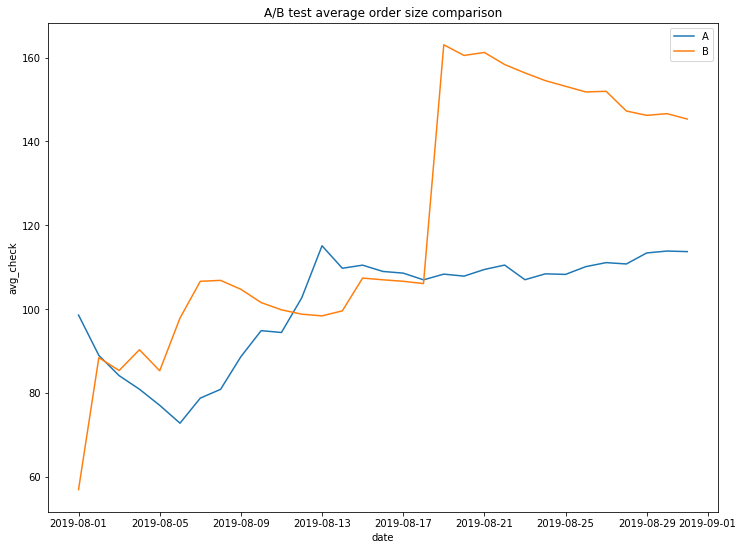

In [28]:
plt.figure(figsize=(12,9))
sns.lineplot(data=orders_aggregated, x = 'date', y = 'avg_check', hue='group')
plt.legend()
plt.title("A/B test average order size comparison")
plt.show()

The situation is very similar here to the previous graph with cumulative revunue comparison. The peak in demand in group B can be seen at the exact same period in August. Overall, Group B seems to have a bigger average order size, but it is up for discussion until the outliers are inversigated.

### Graph the relative difference in cumulative average order size for group B compared with group A.


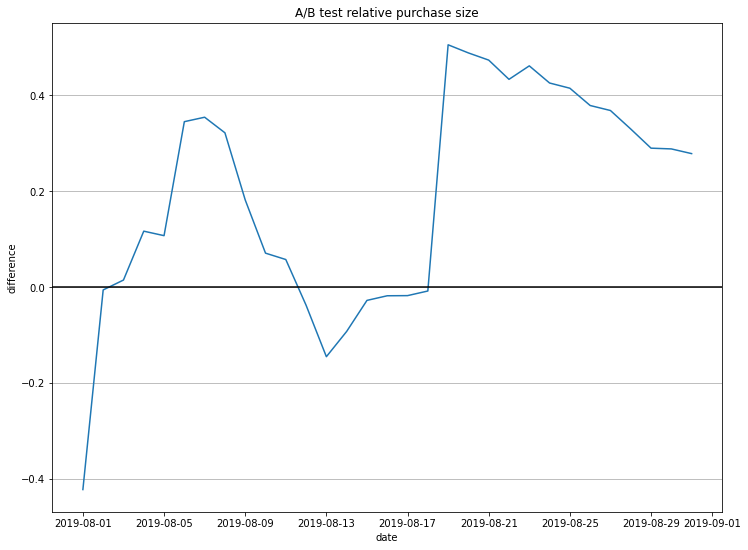

In [29]:
cumulative_avg_checkA = orders_aggregated[orders_aggregated['group']=='A']
cumulative_avg_checkB = orders_aggregated[orders_aggregated['group']=='B']
cumulative_avg_check = cumulative_avg_checkA[['date','avg_check']].merge(cumulative_avg_checkB[['date','avg_check']], how='left', on='date', suffixes=['A','B'])

cumulative_avg_check['difference'] = (cumulative_avg_check['avg_checkB']/cumulative_avg_check['avg_checkA'])-1

plt.figure(figsize=(12,9))
sns.lineplot(data=cumulative_avg_check, x = 'date', y = 'difference')
plt.axhline(y=0, color='black')
plt.grid(axis='y')
plt.title("A/B test relative purchase size")
plt.show()


This graph indicates once more the presence of sudden peaks in demand in first and second half of August that can be attributed to successful marketing campaigns or outliers. We should investigate the outliers to be safe.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. 


In [30]:

# Let's aggregate visit 
visits_aggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
                                     .agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

cum_df = orders_aggregated.merge(visits_aggregated, left_on=['date','group'], right_on=['date','group'], how ='left')
cum_df.columns = ['date','group','orders','visitors','revenue','avg_check','visits']
cum_df['conversion'] = cum_df['orders']/cum_df['visits']
display(cum_df.head())



,date,group,orders,visitors,revenue,avg_check,visits,conversion
0,2019-08-01,A,23,19,2266.6,98.547826,719,0.031989
1,2019-08-01,B,17,17,967.2,56.894118,713,0.023843
2,2019-08-02,A,42,36,3734.9,88.926190,1338,0.031390
3,2019-08-02,B,40,39,3535.3,88.382500,1294,0.030912
4,2019-08-03,A,66,60,5550.1,84.092424,1845,0.035772


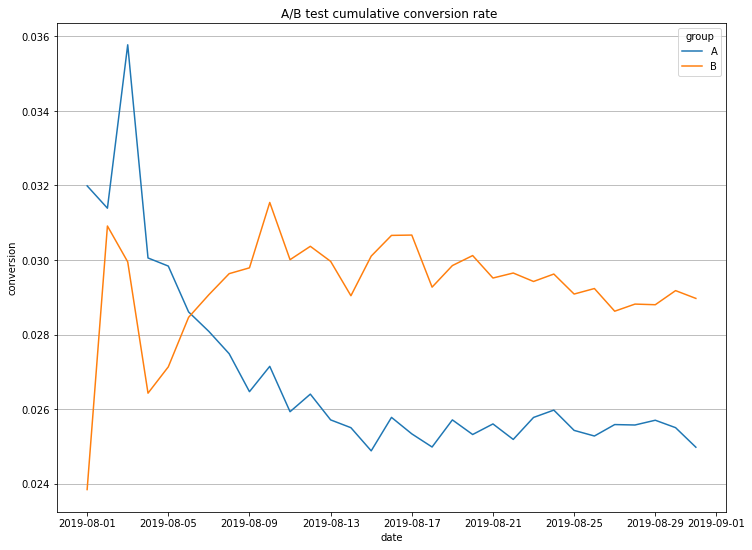

In [31]:
plt.figure(figsize=(12,9))
sns.lineplot(data=cum_df, x = 'date', y = 'conversion', hue='group')
plt.grid(axis='y')
plt.title("A/B test cumulative conversion rate ")
plt.show()

According to the graph above, group B features consistently better results starting August the 9th.

### Plot a scatter chart of the number of orders per user.


In [32]:

ordersbyusers = orders_filtered.groupby(['visitorid','group']).agg({'transactionid':'nunique'}).reset_index()
ordersbyusers.columns = ['visitors','group','orders']
ordersbyusers


,visitors,group,orders
0,5114589,B,1
1,6958315,B,1
2,11685486,A,1
3,39475350,B,1
4,47206413,B,1
...,...,...,...
968,4259830713,A,1
969,4278982564,A,1
970,4279090005,B,1
971,4281247801,B,1


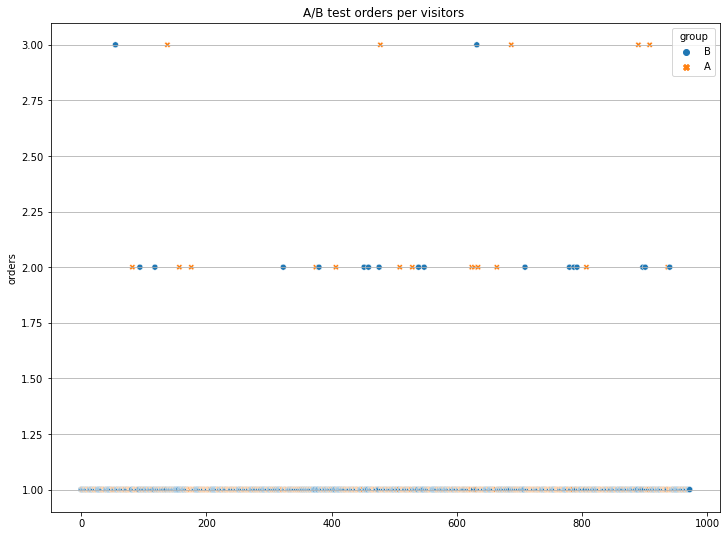

In [33]:
plt.figure(figsize=(12,9))
#Setting up x_values for scatter graph
x_values = pd.Series(range(0, len(ordersbyusers)))
sns.scatterplot(data=ordersbyusers, x = pd.Series(range(0, len(ordersbyusers))), y = 'orders', hue='group', style='group')
plt.grid(axis='y')

plt.title("A/B test orders per visitors ")
plt.show()

There are a few evident outliers in both groups that have 2 orders or above.

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.


In [34]:

print(f"Top 10% report {np.percentile(ordersbyusers['orders'], 90)} orders per user") 
print(f"Top 5% report {np.percentile(ordersbyusers['orders'], 95)} orders per user")
print(f"Top 1% report {np.percentile(ordersbyusers['orders'], 99)} orders per user")

Top 10% report 1.0 orders per user
Top 5% report 1.0 orders per user
Top 1% report 2.0 orders per user


It can be derived from the percentile analysis and the "orders per visitors" scatterplot, that those users that are estimated to have 2 or more orders can be done away with, because they are so few and far between. 

### Plot a scatter chart of order prices.


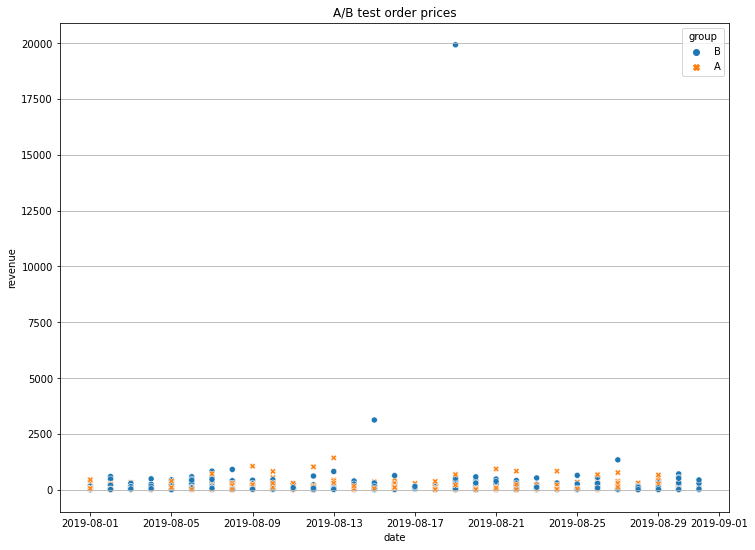

In [35]:
plt.figure(figsize=(12,9))

sns.scatterplot(data=orders_filtered, x = 'date', y = 'revenue', hue='group', style='group')
plt.grid(axis='y')

plt.title("A/B test order prices")
plt.show()

There is one big order in Group B at 20000 mark and another one at approx. 2600-2700. Let's find out what 90,95,99 percentiles are to get a better understanding about outliers.

### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.


In [36]:
print(f"Top 10% of orders are reported to be equal to {np.percentile(orders_filtered['revenue'], 90)}") 
print(f"Top 5% of orders are reported to be equal to {np.percentile(orders_filtered['revenue'], 95)}")
print(f"Top 1% of orders are reported to be equal to {np.percentile(orders_filtered['revenue'], 99)}")

Top 10% of orders are reported to be equal to 280.8
Top 5% of orders are reported to be equal to 414.275
Top 1% of orders are reported to be equal to 830.3


**98% of all data is below 800. Therefore, all the values above 800 in revenue can be regarded as outliers.**

###  Find Statistical significance of the difference in conversion between the groups using the raw data.


Let's calculate the statistical significance of the difference in conversion between the groups.

To do that,Mann-Whitney test is required. It consists of the following steps:

1. Split dataset with orders by users into two groups A and B
2. Create SampleA and SampleB, containing both users who made a puchase and those who didn't
3. Compare the two samples using stats.mannwhitneyu.




Conversion Hypotheses:

H0: Difference in conversion for groups A and B is statistically insignificant.

H1: Difference in conversion for groups A and B is statistically significant.



In [37]:

ordersbyusersA = ordersbyusers.query('group =="A"')

ordersbyusersB = ordersbyusers.query('group =="B"')




In [38]:

sampleA = pd.concat([
    ordersbyusersA['orders'], pd.Series(
        0,index=np.arange(ordersbyusers['visitors'].nunique()-len(ordersbyusersA['orders']))
        ,name='orders')],axis=0)

sampleB = pd.concat([
    ordersbyusersB['orders'], pd.Series(
        0,index=np.arange(ordersbyusers['visitors'].nunique()-len(ordersbyusersB['orders']))
        ,name='orders')],axis=0)




In [39]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
if p_value<alpha:
    print(f'''Reject the null hypothesis: the two samples are in fact different in conversion.
          p_value is: {p_value:.5f}   
          Relative mean conversion Group B/A is {(sampleB.mean()/sampleA.mean()-1):.1%}.''')
else:
    print(f'''Cannot reject the null hypothesis, since statistical difference in conversion between the two samples is not confirmed.)
          p_value is: {p_value:.5f} 
          Relative mean conversion Group B/A is {(sampleB.mean()/sampleA.mean()-1):.1%}.''')


Reject the null hypothesis: the two samples are in fact different in conversion.
          p_value is: 0.00025   
          Relative mean conversion Group B/A is 17.1%.


### Find the statistical significance of the difference in average order size between the groups using raw data


**With statistical difference in conversion between the sets out of the way we can begin analyzing statistical difference in average order size.**

Average order size Hypotheses:

H0: The two groups A and B have statistically insignificant difference in average order sizes.

H1: There is statistically significant difference between the two groups A and B in average order sizes. 


In [40]:
#comparing sample A and sample B by average order size

sample_a = orders_filtered[orders['group']=='A']['revenue']
sample_b = orders_filtered[orders['group']=='B']['revenue']
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a,sample_b)[1]
if p_value<alpha:
    print("Reject the null hypothesis: The two groups A and B have statistically insignificant difference in average order sizes..")
else:
    print("Cannot reject the null hypothesis, because we can not confirm that there is statistical difference in average order size for groups A and B.")
print(f"p_value is: {p_value:.5f}")

#Let's also find the relative difference in average order size between the samples:
print(f"Relative difference in SampleB/SampleA average order size: {orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1:.3%}")



Cannot reject the null hypothesis, because we can not confirm that there is statistical difference in average order size for groups A and B.
p_value is: 0.86223
Relative difference in SampleB/SampleA average order size: 25.165%


/tmp/ipykernel_27/2120243491.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_a = orders_filtered[orders['group']=='A']['revenue']
/tmp/ipykernel_27/2120243491.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_b = orders_filtered[orders['group']=='B']['revenue']


The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that average order size differs between the groups. Nonetheless, the average order size for group B is much bigger than it is for group A.

### Find the statistical significance of the difference in conversion between the groups using the filtered data.

Let's first find the abnormal data and then filter original datasets from it.

In [84]:
#Setting up thresholds
orders_max = 2
rev_max = 800

#Filtering users with abnormal number of orders for A and B groups
users_many_orders = (pd.concat([ordersbyusersA.query('orders > @orders_max')['visitors'],
                     ordersbyusersB.query('orders > @orders_max')['visitors']],axis=0)
                    )
#Filtering users with abnormal amount of revenue for A and B groups
users_big_orders = orders_filtered.query('revenue> @rev_max')['visitorid']

#Merging the tables
abnormalusers = pd.concat([users_many_orders, users_big_orders], axis=0).drop_duplicates()

#Check the result
print(f'''There are {outliers.shape[0]} outliers in our test. 
It is {outliers.shape[0]/orders_filtered.visitorid.nunique():.1%} of our data''')

There are 22 outliers in our test. 
It is 2.3% of our data


In [85]:
print(f" We have {abnormalusers.shape[0]} outliers., that constitute {abnormalusers.shape[0]/ordersbyusers.visitors.nunique():.1%} of the total number of users")


 We have 22 outliers., that constitute 2.3% of the total number of users


**Let's now create two filtered samples and perform a test on conversion**

In [87]:

sampleAFiltered = pd.concat(
    [ordersbyusersA[np.logical_not(ordersbyusersA['visitors'].isin(abnormalusers))]['orders'],
     pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersbyusersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [ordersbyusersB[np.logical_not(ordersbyusersB['visitors'].isin(abnormalusers))]['orders'],
     pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersbyusersB['orders'])),name='orders')],axis=0)

#Performing a statistical test to find out, whether there is statistical difference 
alpha=0.05
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
if results.pvalue <alpha:
    print(f'''
    Filtered groups A and B are statistically different in conversion. p-value is: {results.pvalue:.3f} 
    Relative mean conversion Group B/A is {(sampleBFiltered.mean()/sampleAFiltered.mean()-1):.1%}.
    We reject the null hypothesis.''')
else:
    print(f'''
    We cannot state that there is a statistical difference of conversion for filtered groups A and B. p-value is: {results.pvalue:.3f}.
    Relative mean conversion Group B/A is {(sampleBFiltered.mean()/sampleAFiltered.mean()-1):.1%}. 
    We cannot reject the null hypothesis.''')
    
    






    Filtered groups A and B are statistically different in conversion. p-value is: 0.006 
    Relative mean conversion Group B/A is 19.8%.
    We reject the null hypothesis.


**Let's visualize our findings by plotting linegraphs, featuring cumulative revenue, cumulative conversion rate.**

In [65]:
ordersbyusersB

,visitors,group,orders
0,5114589,B,1
1,6958315,B,1
3,39475350,B,1
4,47206413,B,1
5,48147722,B,1
...,...,...,...
966,4251115836,B,1
967,4258103007,B,1
970,4279090005,B,1
971,4281247801,B,1


In [94]:
orders_filtered

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [88]:


# Select orders from ordersbyusersB and ordersbyusersA without abnormal users
ordersB = ordersbyusersB[np.logical_not(ordersbyusersB['visitors'].isin(abnormalusers))]['visitors']
ordersA = ordersbyusersA[np.logical_not(ordersbyusersA['visitors'].isin(abnormalusers))]['visitors']

# Concatenate the two DataFrames
concatenated_orders = pd.concat([ordersB, ordersA])

# Print the concatenated DataFrame
print(concatenated_orders)


0         5114589
1         6958315
3        39475350
4        47206413
5        48147722
          ...    
960    4227830084
963    4237561104
964    4243832526
968    4259830713
969    4278982564
Name: visitors, Length: 951, dtype: int64


In [97]:
#Filtering the orders_aggregated table of outliers

orders_aggregated_filtered =  orders_filtered.query('visitorid in @concatenated_orders')

display(orders_aggregated_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 1194
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  979 non-null    int64         
 1   visitorid      979 non-null    int64         
 2   date           979 non-null    datetime64[ns]
 3   revenue        979 non-null    float64       
 4   group          979 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 45.9+ KB


None

In [99]:
#Aggregating revenue and counting unique users and orders in orders filtered table
orders_agg_normalusers = datesGroups.apply(lambda x: orders_aggregated_filtered[np.logical_and(orders_aggregated_filtered['date'] <= x['date'], orders_aggregated_filtered['group'] == x['group'])]
                                         .agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique','revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


orders_agg_normalusers



,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,18,17,1779.3
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,36,34,3217.6
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,60,58,5032.8
...,...,...,...,...,...
533,2019-08-29,B,498,482,46871.8
757,2019-08-30,A,435,423,41657.2
690,2019-08-30,B,519,503,50158.6
958,2019-08-31,A,443,431,42505.5


In [103]:
# Let's aggregate visit 
visits_aggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

normalusers_agg =  orders_agg_normalusers.merge(visits_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
normalusers_agg.columns = ['date','group','orders','visitors','revenue','visits']
display(normalusers_agg.head())


normalusers_agg['conversion'] = normalusers_agg['orders']/normalusers_agg['visits']

normalusers_agg.head(5)


,date,group,orders,visitors,revenue,visits
0,2019-08-01,A,18,17,1779.3,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,36,34,3217.6,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,60,58,5032.8,1845


,date,group,orders,visitors,revenue,visits,conversion
0,2019-08-01,A,18,17,1779.3,719,0.025035
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,36,34,3217.6,1338,0.026906
3,2019-08-02,B,40,39,3535.3,1294,0.030912
4,2019-08-03,A,60,58,5032.8,1845,0.032520


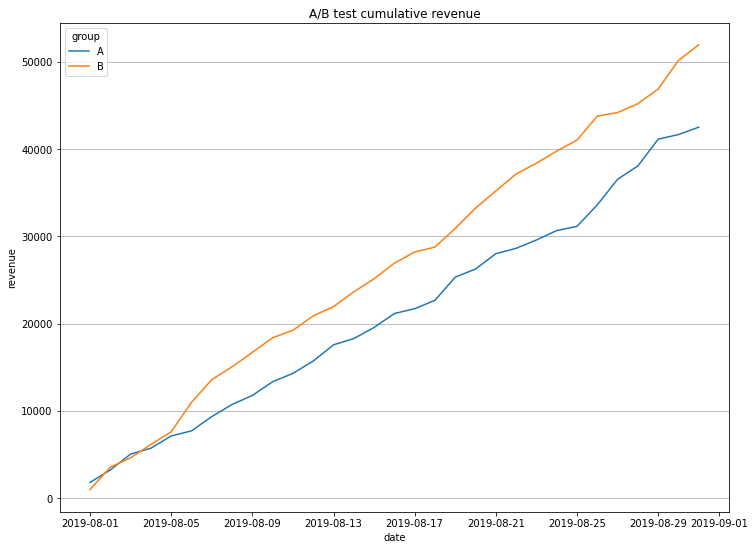

In [102]:
plt.figure(figsize=(12,9))
sns.lineplot(data=normalusers_agg, x = 'date', y = 'revenue', hue='group')
plt.grid(axis='y')
plt.title("A/B test cumulative revenue")
plt.show()

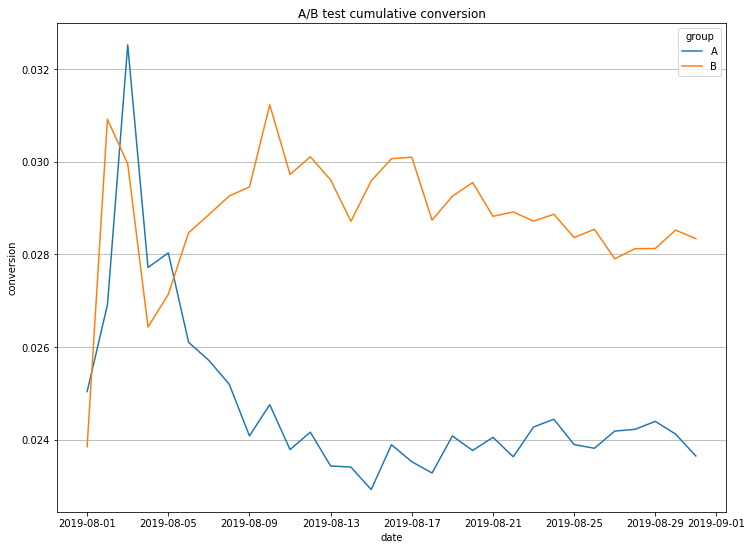

In [104]:
plt.figure(figsize=(12,9))
sns.lineplot(data=normalusers_agg, x = 'date', y = 'conversion', hue='group')
plt.grid(axis='y')
plt.title("A/B test cumulative conversion")
plt.show()

### Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [47]:
### comparing filtered sample A and sample B by average order size


sampleAFiltered_orders = orders_filtered[np.logical_and(
        orders_filtered['group']=='A',
        np.logical_not(orders_filtered['visitorid'].isin(abnormalusers)))]['revenue']
sampleBFiltered_orders =  orders_filtered[np.logical_and(
        orders_filtered['group']=='B',
        np.logical_not(orders_filtered['visitorid'].isin(abnormalusers)))]['revenue']
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered_orders,sampleBFiltered_orders)[1]
    
if p_value<alpha:
    print(f'''Filtered groups A and B are statistically different in order size. p-value is: {p_value:.3f}
Relative mean order size Group B/A is {sampleBFiltered_orders.mean()/sampleAFiltered_orders.mean()-1:.1%}
We reject the null hypothesis''')
else:
    print(f'''We cannot state that there is statistical difference of order size for filtered groups A and B
p-value is: {p_value:.3f} 
Relative mean order size Group B/A is {sampleBFiltered_orders.mean()/sampleAFiltered_orders.mean()-1:.1%}
We cannot reject the null hypothesis''')



We cannot state that there is statistical difference of order size for filtered groups A and B
p-value is: 0.921 
Relative mean order size Group B/A is 2.6%
We cannot reject the null hypothesis


Having conducted a test we can conclude, that order sizes are statistically no different when comparing two filtered samples, with group B having a slight insignificant 2.6% edge over group A.

### Make a decision based on the test results.

Before conducting A/B tests 58 unique visitors, that were falsely assigned to more than one group, have been rooted out. 

Afterwards, cumulative revenue and cumulative order size by each group were graphed and in both cases group B featured better results in comparison to group A. However, when it comes to cumulative average order size analysis, there were fluctuations that could result from from outliers distprting the picture.

Therefore, those users that are estimated to have 2 or more orders and purchases above 800 in revenue were regarded as outliers and excluded from analysis.


The A/B tests consisted of comparing datasets with raw and filtered data on conversion and average order size. The tests were conducted using Mann - Whitney U tests to establish the possible statistical difference.
The results after testing raw data were as follows:
1. SampleA and SampleB are in fact different in conversion.
2. Relative mean conversion Group B/A is 17.1%.
3. There is no significant difference in average order sizes between SampleA and SampleB.
4. Relative difference in SampleB/SampleA average order size: 25.165%


The results after testing filtered data were as follows:
1. Filtered groups A and B are statistically different in conversion. p-value is: 0.007    
2. Relative mean conversion Group B/A is 19.1%.
3. We cannot state that there is statistical difference of order size for filtered groups A and B
4. Relative mean order size Group B/A is 2.6%

As can be observed, filtered data did not bring change to the overall picture, the test results remained almost the same.
Overall, the tests can be regarded as an overall success, because the test group has demonstrated a statistically significant positive change in conversion.  At the same time no positive changes are to be expected, with regards to average order size.